<div align=center>
		
<font size=5>
In the Name of God
<font/>
<p></p>
<br/>
<br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Artifical Intelligence - Dr. Mahdieh Soleimani
</font>
<br/>
<br/>
Fall 2022

<hr/>
<font color=red>
Reinforcment Learning Practical Assignment (50 + 10 points)
</font>
</div>

<ul>
  <li>Some cell's outputs have not been deleted. you can use these to make sure your implementation is correct.</li>
</ul>

In this notebook you will use the [openai gym](https://www.gymlibrary.dev/) library to train agents in two different reinforcment learning environments. the first environment is a very simple grid-world with discrete states. The second environment however, has continous states.  
make sure to upload your model performance video alongside this notebook. We suggest running this notebook on google colab so that you wont face any package errors.

we will first install the necessary packages.

In [1]:
!pip install gym==0.26
!pip install imageio imageio_ffmpeg
!pip install pygame
!pip install pyglet==1.5.1 
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 710 kB 11.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.26.0-py3-none-any.whl size=826299 sha256=a278802d3302ba2ea592810cf7039463b68a81d6521848c3e24332c762350643
  Stored in directory: /root/.cache/pip/wheels/f1/f2/92/63d51de23bd3ef89d87af5663ef0a1b04781ccb9757b6f98d4
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21

the functions below will be used to make a video of the model performance. It will start the environment and choose the best action based on the given Qtable.

In [2]:
from IPython.display import HTML
from base64 import b64encode
import imageio

## comment this part if your not using google colab
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()
######################

def record_video_frozen_lake_env(env, Qtable, out_directory, fps=1, random_action=False):
  images = []  
  done = False
  state, info = env.reset(seed=random.randint(0,500))
  img = env.render()
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.random.randint(4)  if random_action else np.argmax(Qtable[state][:])
    state, reward, done, truncated, info = env.step(action)
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

def show_video(video_path, video_width = 600):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

## Part I: FrozenLake Environment (35 + 10 Points)

In [3]:
import numpy as np
import gym
import random
from tqdm.notebook import tqdm

In this exercise, we want to solve the FrozenLake environment. It is a simple grid-world environment where we have to reach a goal state while avoiding holes.  
You can read more about this environment [here](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/)

**[Question 1 (1 Points)]**  
Create a <u>slippery</u> FrozenLake environment of size <u>4x4</u>

In [4]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode='rgb_array')

Let's run a random policy in this environement to get a better understanding of it.

In [5]:
record_video_frozen_lake_env(env, None, 'frozenlake_random.mp4', fps=1, random_action=True)
show_video('frozenlake_random.mp4', video_width = 600)

**[Question 2 (1 Points)]**  
Briefly describe the state space, action space, and reward function of this environment.

**Answer:**  
State space: Each square in the grid. (16 states in this problem.) <br>
Action space: Moving up, down, left or right. <br>
Reward function: Reaching goal(G): +1, reaching frozen(F): 0, reaching hole(H): 0.

**[Question 3 (2 Points)]**  
Complete the code for `initialize_q_table` function. It should create a Q-table of size (state_space, action_space) and initializes it. You are free to use whichever initialization you want (a good starting point is to initialize it with all zeros)

In [6]:
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

In [15]:
Qtable = initialize_q_table(16, 4)
print(Qtable)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


**[Question 4 (2 Points)]**  
Complete the code for `epsilon_greedy_policy` function. It should select the best action according to the current Q-function with probability $1-\varepsilon$ and select a random action with probability $\varepsilon$.

In [8]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  x = np.random.uniform(0, 1)
  if x >= epsilon:
    action = np.argmax(Qtable, axis=1)[state]
  else:
    action = random.randint(0, 3)
  return action

**[Question 5 (4 Points)]**  
You need to choose appropriate hyperparameters for the agent to learn.

In particular, you must find a suitable learning rate and exploration parameters. To facilitate exploration, a common practice is to start with a high exploration rate ($\varepsilon$) and gradually decrease it as the agent gets better. To implement this, you need to specify the starting exploration rate (`max_epsilon`), the final exploration rate (`min_epsilon`) and a decay rate which reduces the exploration rate after each update (see the `train` function below).

In [61]:
# Training parameters
n_training_episodes = 50_000  # Total training episodes
n_eval_episodes = 10_000
learning_rate = 0.01          # Learning rate

# Environment parameters
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
max_epsilon = 0.3             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.95            # Exponential decay rate for exploration prob

**[Question 6 (10 Points)]**  
Complete the `train` function which updates `Qtable` using the Q-learning update rule.

In [34]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in tqdm(range(n_training_episodes)):
    # Adjust epsilon
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state, info = env.reset()
    step = 0
    done = False

    # repeat
    for step in range(max_steps):
      # You must:
      # Take action A_t and observe R_{t+1}, S_{t+1}
      # Update the Qtable with (S_t, A_t, R_{t+1}, S_{t+1})
      # Be careful about episode termination and truncation
      action = epsilon_greedy_policy(Qtable, state, epsilon)
      new_state, reward, done, truncated, info = env.step(action)
      max_Q = np.amax(Qtable, axis=1)[new_state]
      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * max_Q - Qtable[state][action])
      state = new_state
      if done:
        break


  return Qtable

We are now ready to train our agent.

In [62]:
Qtable_trained = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [63]:
print(Qtable_trained)

[[0.17967657 0.16812813 0.16557841 0.16240728]
 [0.10161621 0.10509524 0.09996915 0.15612842]
 [0.15492174 0.13890802 0.13858347 0.13601283]
 [0.09366576 0.09144333 0.08853315 0.1250114 ]
 [0.21152833 0.14643068 0.15607898 0.13162401]
 [0.         0.         0.         0.        ]
 [0.17960576 0.1285243  0.14018969 0.05176468]
 [0.         0.         0.         0.        ]
 [0.14894889 0.20708263 0.1899799  0.27051347]
 [0.24391307 0.36314572 0.28439598 0.21832972]
 [0.38050439 0.33512309 0.31782364 0.17714141]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.27537524 0.3751953  0.49951547 0.32705239]
 [0.52227483 0.71548134 0.65493257 0.60628702]
 [0.         0.         0.         0.        ]]


Now, we will evaluate our agent. You don't need to write any code, just run the following cells as they are.

In [68]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param Q: The Q-table
  """
  episode_rewards = []
  for episode in tqdm(range(n_eval_episodes)):
    state, info = env.reset()
    step = 0
    terminated = False
    total_rewards_ep = 0
    
    for step in range(max_steps):
      action = np.argmax(Q[state][:])
      new_state, reward, terminated, truncated, info = env.step(action)
      total_rewards_ep += reward
        
      if terminated:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [69]:
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_trained)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}") # should be around 0.65

  0%|          | 0/10000 [00:00<?, ?it/s]

Mean_reward=0.73 +/- 0.44


Now let's see how well our model is doing.

In [70]:
record_video_frozen_lake_env(env, Qtable_trained, 'frozenlake_trained.mp4', fps=1)
show_video('frozenlake_trained.mp4', video_width = 600)

Next, we will take a look at the Q-function that was learned.

In [67]:
print(Qtable_trained)

[[0.17967657 0.16812813 0.16557841 0.16240728]
 [0.10161621 0.10509524 0.09996915 0.15612842]
 [0.15492174 0.13890802 0.13858347 0.13601283]
 [0.09366576 0.09144333 0.08853315 0.1250114 ]
 [0.21152833 0.14643068 0.15607898 0.13162401]
 [0.         0.         0.         0.        ]
 [0.17960576 0.1285243  0.14018969 0.05176468]
 [0.         0.         0.         0.        ]
 [0.14894889 0.20708263 0.1899799  0.27051347]
 [0.24391307 0.36314572 0.28439598 0.21832972]
 [0.38050439 0.33512309 0.31782364 0.17714141]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.27537524 0.3751953  0.49951547 0.32705239]
 [0.52227483 0.71548134 0.65493257 0.60628702]
 [0.         0.         0.         0.        ]]


**[Question 7 (5 Points)]**  
Assume that `Qtable_trained` is the correct Q-function for the final epsilon-greedy policy that was used in training. What is the value function that corresponds to this policy? Write down the relation between $V_\pi$ and $Q_\pi$ and use it to complete the following code block.

**Answer:**
$$V_\pi (s) = \max_a{Q_\pi (s, a)}$$

In [71]:
Vtable_trained = np.amax(Qtable_trained, axis=1)

Take a look at the value function

In [72]:
print(Vtable_trained)

[0.17967657 0.15612842 0.15492174 0.1250114  0.21152833 0.
 0.17960576 0.         0.27051347 0.36314572 0.38050439 0.
 0.         0.49951547 0.71548134 0.        ]


**[Question 8 (5 Points)]**  
Write a function to generate a visualization for the value function using a heatmap. In a few words, explain what you see.

In [75]:
import seaborn as sns

def visualize(Vtable):
  table = Vtable.reshape((4, 4))
  sns.heatmap(table)

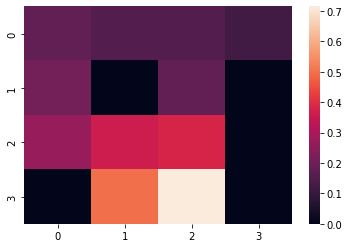

In [76]:
visualize(Vtable_trained)

**[Question 9 (5 Points)]**  
Can we use a pure greedy policy for Q-learning? Explain.

**Answer:**

Instead of acting randomly to reach the goal and fill the table, we could start from random states and calculate Q-values using greedy policy from there, and in each step, modify the Bellman equations such that they still hold for different starting points. (for exapamle, when we start from a zero Q-value and reach to a non-zero Q-value that was a starting state for previous iterations, we could count number of steps to reach that state ($n$), and multiply reminder of the path to goal by a factor of $\gamma^{n}$.

**[Bonus Question (10 Points)]**  
Think about the role of the discount factor in this environment and experiment.  
1. Explain why it is not the best idea to set $\gamma = 1$ for a navigation task. You might find it easier to reason about a deterministic (i.e., non-slippery) environment. (5 Points)
2. If we had used $\gamma = 1$, the value of states could be interpreted in a meaningful way. Think about what $V^*(s)$ would be if we had set $\gamma = 1$ and trained until we got the optimal value function. (5 Points)

**Answer:**

1. Because setting $\gamma$ to 1 means that we don't penalize late arrival to the goal, which means our optimal answer could be long, which increases the chance of reaching holes. On the other hand, value iterartion will be slower to converge, because depth of the search tree could be much larger.
2. When $γ = 1$, $V^*(s)$ is basically the probablity of reaching the goal from the state $s$ if the agent obeys the optima policy.

# Part II: Mountain Car Environment (15 point)

The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill.

lets create the environment.

In [139]:
env = gym.make("MountainCar-v0", render_mode='rgb_array')

The state of the car is represented by its velocity and position along the x axis. the velocity is a number between -0.07, 0.07 and the position is a number between -1.3, 0.6. There are 3 discrete deterministic actions: (0:Accelerate to the left, 1:Don’t accelerate, 2:Accelerate to the right)
The starting position of the car is different each time we run the environment.

In order to use the same Q learning algorithm on this environment we need to somehow discretize the states. We can easily do this by dividing the range of the observation into smaller range.   
its important how small we divide these range. if the step size is too big we might not achieve a good accuracy and if the step size is too small we will have a bigger observation space.  

**[Question 10 (5 Points)]**  
implement the next  discretization function.

In [89]:
def discretize(x, min_value, step_size):
    return int(np.floor((x - min_value) / step_size))

assert(discretize(0.222, 0.1, 0.1)==1)
assert(discretize(0.134, 0.1, 0.1)==0) 

we will use step size 0.1 for the position and the step size 0.01 for the velocity. the following function will discretize a state using the function you implemented above.

In [90]:
def discretize_state(state, step_velocity=0.01, step_position=0.1):
  position , velocity = state
  position = discretize(position, -1.3, step_position)
  velocity = discretize(velocity, -0.07, step_velocity)
  if position==19:
    position = 18
  if velocity==14:
    velocity = 13
  return (position, velocity)

the function below will run the mountain car experiment and output a video. We will use it to run an agent with a random policy.

In [91]:
def record_video_mountain_car_env(env, Qtable, out_directory, fps=1, random_action=False, max_episode=500):
  images = []  
  truncated, done = False, False
  state, info = env.reset(seed=random.randint(0,500))
  state = discretize_state(state)
  img = env.render()
  images.append(img)
  episode = 0
  while episode < max_episode and not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.random.randint(3)  if random_action else np.argmax(Qtable[state[0]][state[1]][:])
    state, reward, done, truncated, info = env.step(action)
    state = discretize_state(state)
    img = env.render()
    images.append(img)
    episode += 1
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

def show_video(video_path, video_width = 600):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

record_video_mountain_car_env(env, None, 'mountaincar_random.mp4', fps=15, random_action=True)
show_video('mountaincar_random.mp4', video_width = 600)

**[Question 11 (2 Points)]**  
Implement the next functions like you did the previous part. 

In [127]:
from os import stat_result
def initialize_q_table(step_size_velocity, step_size_pos, action_space):
  # Qtable should be of the shape (discrete position value, discrete velocity value, action_no)
  position_no = int(np.floor(1.9 / step_size_pos)) + 1
  velocity_no = int(np.floor(0.14 / step_size_velocity))
  Qtable = np.zeros((position_no, velocity_no, 3))
  return Qtable

def epsilon_greedy_policy(Qtable, state, epsilon):
  x = np.random.uniform(0, 1)
  stat_result = discretize_state(state)
  if x >= epsilon:
    action = np.argmax(Qtable[state[0]][state[1]][:])
  else:
    action = random.randint(0, 2)
  return action

Qtable = initialize_q_table(0.01, 0.1, 3)
print(Qtable.shape)

(19, 14, 3)


**[Question 12 (8 Points)]**  
Change the previous train function so it works in this environment.

In [145]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in tqdm(range(n_training_episodes)):
    # Adjust epsilon
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state, info = env.reset()
    state = discretize_state(state)
    step = 0
    done = False

    # repeat
    for step in range(max_steps):
      action = epsilon_greedy_policy(Qtable, state, epsilon)
      new_state, reward, done, truncated, info = env.step(action)
      new_state = discretize_state(new_state)
      max_Q = np.amax(Qtable[new_state[0]][new_state[1]][:])
      Qtable[state[0]][state[1]][action] = Qtable[state[0]][state[1]][action] + learning_rate * (reward + gamma * max_Q - Qtable[state[0]][state[1]][action])
      state = new_state
      if done:
        break

  return Qtable

Now lets train our model. You can change the hyperparameters if you want.

In [151]:
# Training parameters
n_training_episodes = 5_000  # Total training episodes
learning_rate = 0.1           # Learning rate

# Environment parameters
max_steps = 500               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 2e-3            # Exponential decay rate for exploration prob

In [152]:
Qtable_trained = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable)

  0%|          | 0/5000 [00:00<?, ?it/s]

Now let us inspect how well our model is doing. In order to pass the assignment, the car must reach the goal.

In [153]:
record_video_mountain_car_env(env, Qtable_trained, 'mountaincar_random.mp4', fps=15)
show_video('mountaincar_random.mp4', video_width = 600)